In [2]:
import json
from rouge_score import rouge_scorer
import random
import pickle  # 用于保存变量

# 1) 加载 JSONL 文件
def load_personas(file_path):
    personas = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            persona = json.loads(line.strip())
            personas.append(persona)
    return personas

# 2) 提取指定字段文本数据
def extract_all_text(persona):
    text_data = []
    def recursive_extract(data):
        if isinstance(data, dict):
            for key, value in data.items():
                recursive_extract(value)
        elif isinstance(data, list):
            for item in data:
                recursive_extract(item)
        elif isinstance(data, str):
            text_data.append(data)

    # 仅提取 "Persona" 字段（原注释写"FilledValues"，你可按需修改）
    recursive_extract(persona["Persona"])
    return ' '.join(text_data)

# 3) 去重逻辑：如果两条 persona 的文本内容一模一样，只保留一条
def deduplicate_personas(personas):
    unique_personas = []
    seen_texts = set()
    for p in personas:
        text = extract_all_text(p)
        if text not in seen_texts:
            seen_texts.add(text)
            unique_personas.append(p)
    return unique_personas

# 4) 计算每个文件中 persona 的最大 ROUGE-L 分数
def calculate_max_rouge_scores(personas, sample_size=5000):
    # 随机采样
    sample_size = min(sample_size, len(personas))
    sampled_personas = random.sample(personas, sample_size)
    
    # 提取文本
    texts = [extract_all_text(persona) for persona in sampled_personas]
    
    # 初始化 ROUGE 计算器
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    
    max_rouge_l_scores = []

    # 计算两两之间的 ROUGE-L 分数，取最大值
    for i, text1 in enumerate(texts):
        max_score = 0.0
        for j, text2 in enumerate(texts):
            if i != j:  # 不与自身比较
                score = scorer.score(text1, text2)['rougeL'].fmeasure
                max_score = max(max_score, score)
        max_rouge_l_scores.append(max_score)

    return max_rouge_l_scores

# ==================== 主程序执行部分 ====================
if __name__ == "__main__":
    # 加载 personas 文件
    file1_path = 'Book_test.jsonl'
    file2_path = 'random_personas.jsonl'
    personas_file1 = load_personas(file1_path)
    personas_file2 = load_personas(file2_path)

    # 对 persona 进行去重
    personas_file1 = deduplicate_personas(personas_file1)
    personas_file2 = deduplicate_personas(personas_file2)

    # 计算并保存分数数据（这里 sample_size=100 仅作示例，可调整）
    max_rouge_l_scores_file1 = calculate_max_rouge_scores(personas_file1, sample_size=100)
    max_rouge_l_scores_file2 = calculate_max_rouge_scores(personas_file2, sample_size=100)

    # 保存数据到 .pkl 文件中
    with open("max_rouge_scores.pkl", "wb") as f:
        pickle.dump({
            "persona_scores": max_rouge_l_scores_file1,
            "random_persona_scores": max_rouge_l_scores_file2
        }, f)

    print("去重后，已计算 ROUGE-L 分数并将结果保存到 max_rouge_scores.pkl。")


去重后，已计算 ROUGE-L 分数并将结果保存到 max_rouge_scores.pkl。


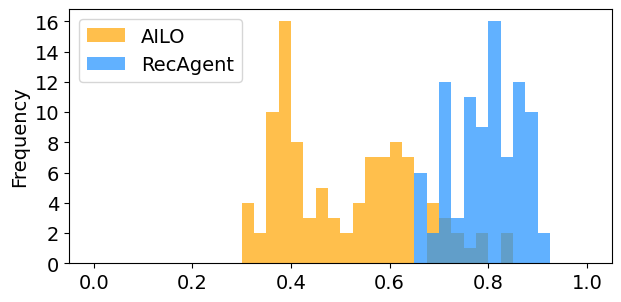

In [4]:
import matplotlib.pyplot as plt

# 假设我们有两个数据集的分数
# max_rouge_l_scores_file1 和 max_rouge_l_scores_file2 是之前计算的分数列表

# 绘制在同一张图中，调整分区数量
plt.figure(figsize=(7, 3.3))
plt.hist(max_rouge_l_scores_file1, bins=40, range=(0, 1), alpha=0.7, color='#FFA500', label='AILO')  
plt.hist(max_rouge_l_scores_file2, bins=40, range=(0, 1), alpha=0.7, color='#1E90FF', label='RecAgent')

# 设置字体大小
#plt.xlabel('Maximum ROUGE-L Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
#plt.title('Distribution of Maximum ROUGE-L Scores', fontsize=16)

# 调整图例位置到左上角
plt.legend(loc='upper left', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('rouge_score.pdf', bbox_inches='tight', transparent=True)
plt.show()
